# Kheireddine SATOURI
# M2 IASD Apprentissage 2023-2024
# LLM Project : Text classification using Transformers.
This AI project aims to develop a text classification system using the IMDb dataset. The focus will be on encoder-based transformer architecture, specifically the well-known model **BERT**.

---

# Introduction

## Strategy
I will experiment with the HuggingFace library, which provides a convenient API for working with transformer models such as BERT, GPT, and others. According to their website: *Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models. Using pretrained models can reduce our compute costs, carbon footprint, and save us the time and resources required to train a model from scratch. Transformers support framework interoperability between PyTorch, TensorFlow, and JAX.*

In [1]:
%%capture
!pip install transformers datasets

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer
from tqdm.notebook import tqdm


import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Download the training data

In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


## Prepare model inputs

The input format to BERT looks like it is  "over-specified", especially if we focus on just one type task: sequence classification, word tagging, paraphrase detection, ...  The format:
- Add special tokens to the start and end of each sentence.
- Pad & truncate all sentences to a single constant length.
- Explicitly differentiate real tokens from padding tokens with the "attention mask".

It looks like that:

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

If we don't want to recreate this kind of inputs with our own hands, we can use the pre-trained tokenizer associated to BERT. Moreover the function `encode_plus` will:
- Tokenize the sentence.
- Prepend the `[CLS]` token to the start.
- Append the `[SEP]` token to the end.
- Map tokens to their IDs.
- Pad or truncate the sentence to `max_length`
- Create attention masks for `[PAD]` tokens.


> 💡 *Note:* For computational reasons, I will use the [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) model, which is a 40% smaller than the original BERT model but still achieve about 95% of the performances of the original model.

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Let's see how the tokenizer actually process the sequence:

In [5]:
# Some useful steps:
message = "hello my name is kevin"
tok = tokenizer.tokenize(message)
print("Tokens in the sequence:", tok)
enc = tokenizer.encode(tok)
table = np.array(
    [
        enc,
        [tokenizer.ids_to_tokens[w] for w in enc],
    ]
).T
print("Encoded inputs:")
print(tabulate(table, headers=["Token IDs", "Tokens"], tablefmt="fancy_grid"))

Tokens in the sequence: ['hello', 'my', 'name', 'is', 'kevin']
Encoded inputs:
╒═════════════╤══════════╕
│   Token IDs │ Tokens   │
╞═════════════╪══════════╡
│         101 │ [CLS]    │
├─────────────┼──────────┤
│        7592 │ hello    │
├─────────────┼──────────┤
│        2026 │ my       │
├─────────────┼──────────┤
│        2171 │ name     │
├─────────────┼──────────┤
│        2003 │ is       │
├─────────────┼──────────┤
│        4901 │ kevin    │
├─────────────┼──────────┤
│         102 │ [SEP]    │
╘═════════════╧══════════╛


> 💡 *Note:* Special tokens like  `[CLS]` and `[SEP]` indicate the beginning and end of a document to the model.
They are also used further for some specific tasks like text classification: for text classification the `[CLS]` embedding is used as a global vectorial representation of the whole text.

## Data pre-processing

Usual data-processing for torch.

In [6]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer.encode(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )
    x["labels"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [7]:
n_samples = 2000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["input_ids", "labels"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=256, return_tensors="pt"
        )
        return features

In [9]:
data_collator = DataCollator(tokenizer)

In [10]:
batch_size = 4

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

# Model from scratch

For this task, I will start from a randomly initialized model.

## Retrieve the architecture configuration

In HuggingFace, model's parameters are specified through a `config` file. It is a json-like object.

We can retrieve the one from the official model with the following code:

In [11]:
from transformers import DistilBertConfig

model_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
print(model_config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.41.2",
  "vocab_size": 30522
}



- `dim` is the embedding dimension
- `hidden_dim` is the dimension for the feedforward layers
- `max_position_embeddings` is the maximum number of parameters that can be handled by the model
- `n_heads` is the number of attention heads (not detailed during the course, but basically the attention is computed not on the whole vector but on `n_heads` subsets and the result is then aggregated)
- `n_layers` is the number of layers
- `vocab_size` is the number of tokens in the vocabulary

For our first experiment, I want to build from a standard stack of transformer layers, without any additional task-specific head.

I will Examine the model obtained after instantiating the model.

In [12]:
from transformers import DistilBertModel

bert = DistilBertModel(model_config)

In [13]:
print(bert)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, i printed out the names and dimensions of the weights for:

- The embedding layer
- The first of the twelve transformers
- The output layer.



In [14]:
# Get all of the model's parameters as a list of tuples.
params = list(bert.named_parameters())

In [15]:
print("The BERT model has {:} different named parameters.\n".format(len(params)))

print("==== Embedding Layer ====\n")

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer Layer ====\n")

for p in params[4:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 100 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer Layer ====

transformer.layer.0.attention.q_lin.weight                (768, 768)
transformer.layer.0.attention.q_lin.bias                      (768,)
transformer.layer.0.attention.k_lin.weight                (768, 768)
transformer.layer.0.attention.k_lin.bias                      (768,)
transformer.layer.0.attention.v_lin.weight                (768, 768)
transformer.layer.0.attention.v_lin.bias                      (768,)
transformer.layer.0.attention.out_lin.weight              (768, 768)
transformer.layer.0.attention.out_lin.bias                    (768,)
transformer.layer.0.sa_layer_norm.weight                 

At this level, I will test my bert model, but before that, i will just look at the output of the model on one batch.


In [16]:
batch = next(iter(train_dataloader))

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]

output = bert(input_ids, attention_mask=attention_mask)
print(output["last_hidden_state"].shape)

torch.Size([4, 256, 768])


## Building a classifier

Our `bert` model is simply a stack of transformer layers. I would like to use it as a backbone for text classification.


Now I have to wrap the model into a classifier. I will use the last hidden [CLS] vector representation to perform classification.

In [17]:
class DistilBertClassifier(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.drop = nn.Dropout(0.3)
        self.linear = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, **kwargs):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = bert_output["last_hidden_state"]  # (bs, seq_len, dim)
        cls_hidden_state = hidden_state[:, 0, :] # (bs, dim)
        cls_hidden_state = self.drop(cls_hidden_state)
        output = self.linear(cls_hidden_state) # (bs, 1)
        return output

In [18]:
bert = DistilBertModel(model_config)
model = DistilBertClassifier(bert)
model.to(DEVICE)

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

Now i will test the model on the batch to make sure that it has the right shape.

In [19]:
out = model(
    input_ids=batch["input_ids"].cuda(), attention_mask=batch["attention_mask"].cuda()
)
print(out.shape)

torch.Size([4, 1])


### Training

At this level, I'm ready to train the model.  


Quantities per epoch to track :
- training loss
- training accuracy
- validation loss
- validation accuracy

In [20]:
def validation(model, valid_dataloader):
    total_size = 0
    acc_total = 0
    loss_total = 0
    criterion = nn.BCEWithLogitsLoss()
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            batch = {k: v.cuda() for k, v in batch.items()}
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            attention_mask = batch["attention_mask"]
            labels = labels.float()
            preds = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(preds.squeeze(), labels)
            acc = (preds.squeeze() > 0) == labels
            total_size += acc.shape[0]
            acc_total += acc.sum().item()
            loss_total += loss.item()
    model.train()
    return loss_total / len(valid_dataloader), acc_total / total_size


validation(model, valid_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

(0.7151216852664948, 0.5275)

In [21]:
def training(model, n_epochs, train_dataloader, valid_dataloader, lr=5e-5):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        eps=1e-08,
    )
    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []
    criterion = nn.BCEWithLogitsLoss()
    for e in range(n_epochs):
        # ========== Training ==========

        # Set model to training mode
        model.train()
        model.to(DEVICE)

        # Tracking variables
        train_loss = 0
        epoch_train_acc = 0
        for batch in tqdm(train_dataloader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            input_ids, attention_mask, labels = (
                batch["input_ids"],
                batch["attention_mask"],
                batch["labels"],
            )
            optimizer.zero_grad()
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Backward pass
            loss = criterion(outputs.squeeze(), labels.squeeze().float())
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()
            acc = (outputs.squeeze() > 0) == labels.squeeze()
            epoch_train_acc += acc.float().mean().item()
        list_train_acc.append(100 * epoch_train_acc / len(train_dataloader))
        list_train_loss.append(train_loss / len(train_dataloader))

        # ========== Validation ==========

        l, a = validation(model, valid_dataloader)
        list_val_loss.append(l)
        list_val_acc.append(a * 100)
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Train acc: {:.4f}".format(list_train_acc[-1]),
            "Val loss: {:.4f}".format(l),
            "Val acc:{:.4f}".format(a * 100),
        )
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [22]:
bert = DistilBertModel(model_config)
model = DistilBertClassifier(bert)
model.to(DEVICE)

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [23]:
batch_size = 16

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

In [24]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model, 3, train_dataloader, valid_dataloader
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

0 
	 - Train loss: 0.7707 Train acc: 50.7500 Val loss: 0.7053 Val acc:51.0000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

1 
	 - Train loss: 0.6634 Train acc: 58.5625 Val loss: 0.5673 Val acc:71.7500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

2 
	 - Train loss: 0.3911 Train acc: 81.1875 Val loss: 0.5473 Val acc:76.7500


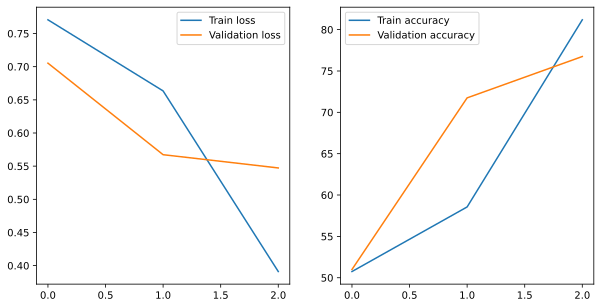

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[1].plot(list_train_acc, label="Train accuracy")
axs[1].plot(list_val_acc, label="Validation accuracy")
axs[0].plot(list_train_loss, label="Train loss")
axs[0].plot(list_val_loss, label="Validation loss")

axs[1].legend()
axs[0].legend()

plt.show()

## Pre-trained model

Now I'm going to compare with a pre-trained model.

First, I'm going to load the model's weights from the HuggingFace hub.

In [27]:
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
model = DistilBertClassifier(bert)
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

## Fine-Tuning

With our model loaded and ready,  we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4

I chose:
* Batch size: 16 (set when creating our DataLoaders)
* Learning rate: 5e-5
* Epochs: 3 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

Now, I will build classifier and train it with the pre-trained checkpoint.

In [28]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model, 3, train_dataloader, valid_dataloader, lr=5e-6
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

0 
	 - Train loss: 0.6556 Train acc: 61.6250 Val loss: 0.5275 Val acc:81.2500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

1 
	 - Train loss: 0.4000 Train acc: 83.1250 Val loss: 0.3374 Val acc:86.7500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

2 
	 - Train loss: 0.2643 Train acc: 89.5625 Val loss: 0.3162 Val acc:87.5000


## Final Step: Benchmarking with Real Prompt Tests

In [38]:
def classify_text(text, model, tokenizer):
    tokenized_text = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    model_output = model(
        input_ids=tokenized_text["input_ids"].to(DEVICE),
        attention_mask=tokenized_text["attention_mask"].to(DEVICE)
    )
    logits = model_output[0]
    pred = torch.sigmoid(logits).item() > 0.5
    result = "Positive review" if pred else "Negative review"
    return text, result

In [78]:
# List of prompts to classify
texts = [
    "captain corelli's mandolin is a beautiful film with a lovely cast. i'd advise anyone to go and see it. brilliant! 10 / 10",
    "the plot of 'Batman v Superman' was weak and the characters were poorly developed. not worth watching.",
    "an absolute masterpiece! 'The Shawshank Redemption' direction and acting were top-notch.",
    "i found the movie 'Twilight' quite boring and predictable.",
    "a delightful surprise! the humor in 'The Grand Budapest Hotel' was spot on and the storyline was engaging.",
    "the quality of the image is poor and it detracts from the overall experience.",
    "The quality of the image is poor and it detracts from the overall experience, but there is wisdom in the story that I like, so i give it 3 / 5"
]

In [80]:
for text in texts:
    text, result = classify_text(text, model, tokenizer)
    print("---------------------------------------------")
    print(f"Text: '{text}'\nResult: {result}")

---------------------------------------------
Text: 'captain corelli's mandolin is a beautiful film with a lovely cast. i'd advise anyone to go and see it. brilliant! 10 / 10'
Result: Positive review
---------------------------------------------
Text: 'the plot of 'Batman v Superman' was weak and the characters were poorly developed. not worth watching.'
Result: Negative review
---------------------------------------------
Text: 'an absolute masterpiece! 'The Shawshank Redemption' direction and acting were top-notch.'
Result: Positive review
---------------------------------------------
Text: 'i found the movie 'Twilight' quite boring and predictable.'
Result: Negative review
---------------------------------------------
Text: 'a delightful surprise! the humor in 'The Grand Budapest Hotel' was spot on and the storyline was engaging.'
Result: Positive review
---------------------------------------------
Text: 'the quality of the image is poor and it detracts from the overall experience.